## Assignment #2 (demo) Analyzing cardiovascular disease data

Link to the the assignment:
https://mlcourse.ai/book/topic02/assignment02_analyzing_cardiovascular_desease_data.html

### Importing Necessary Libraries

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

### Importing Data

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [3]:
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


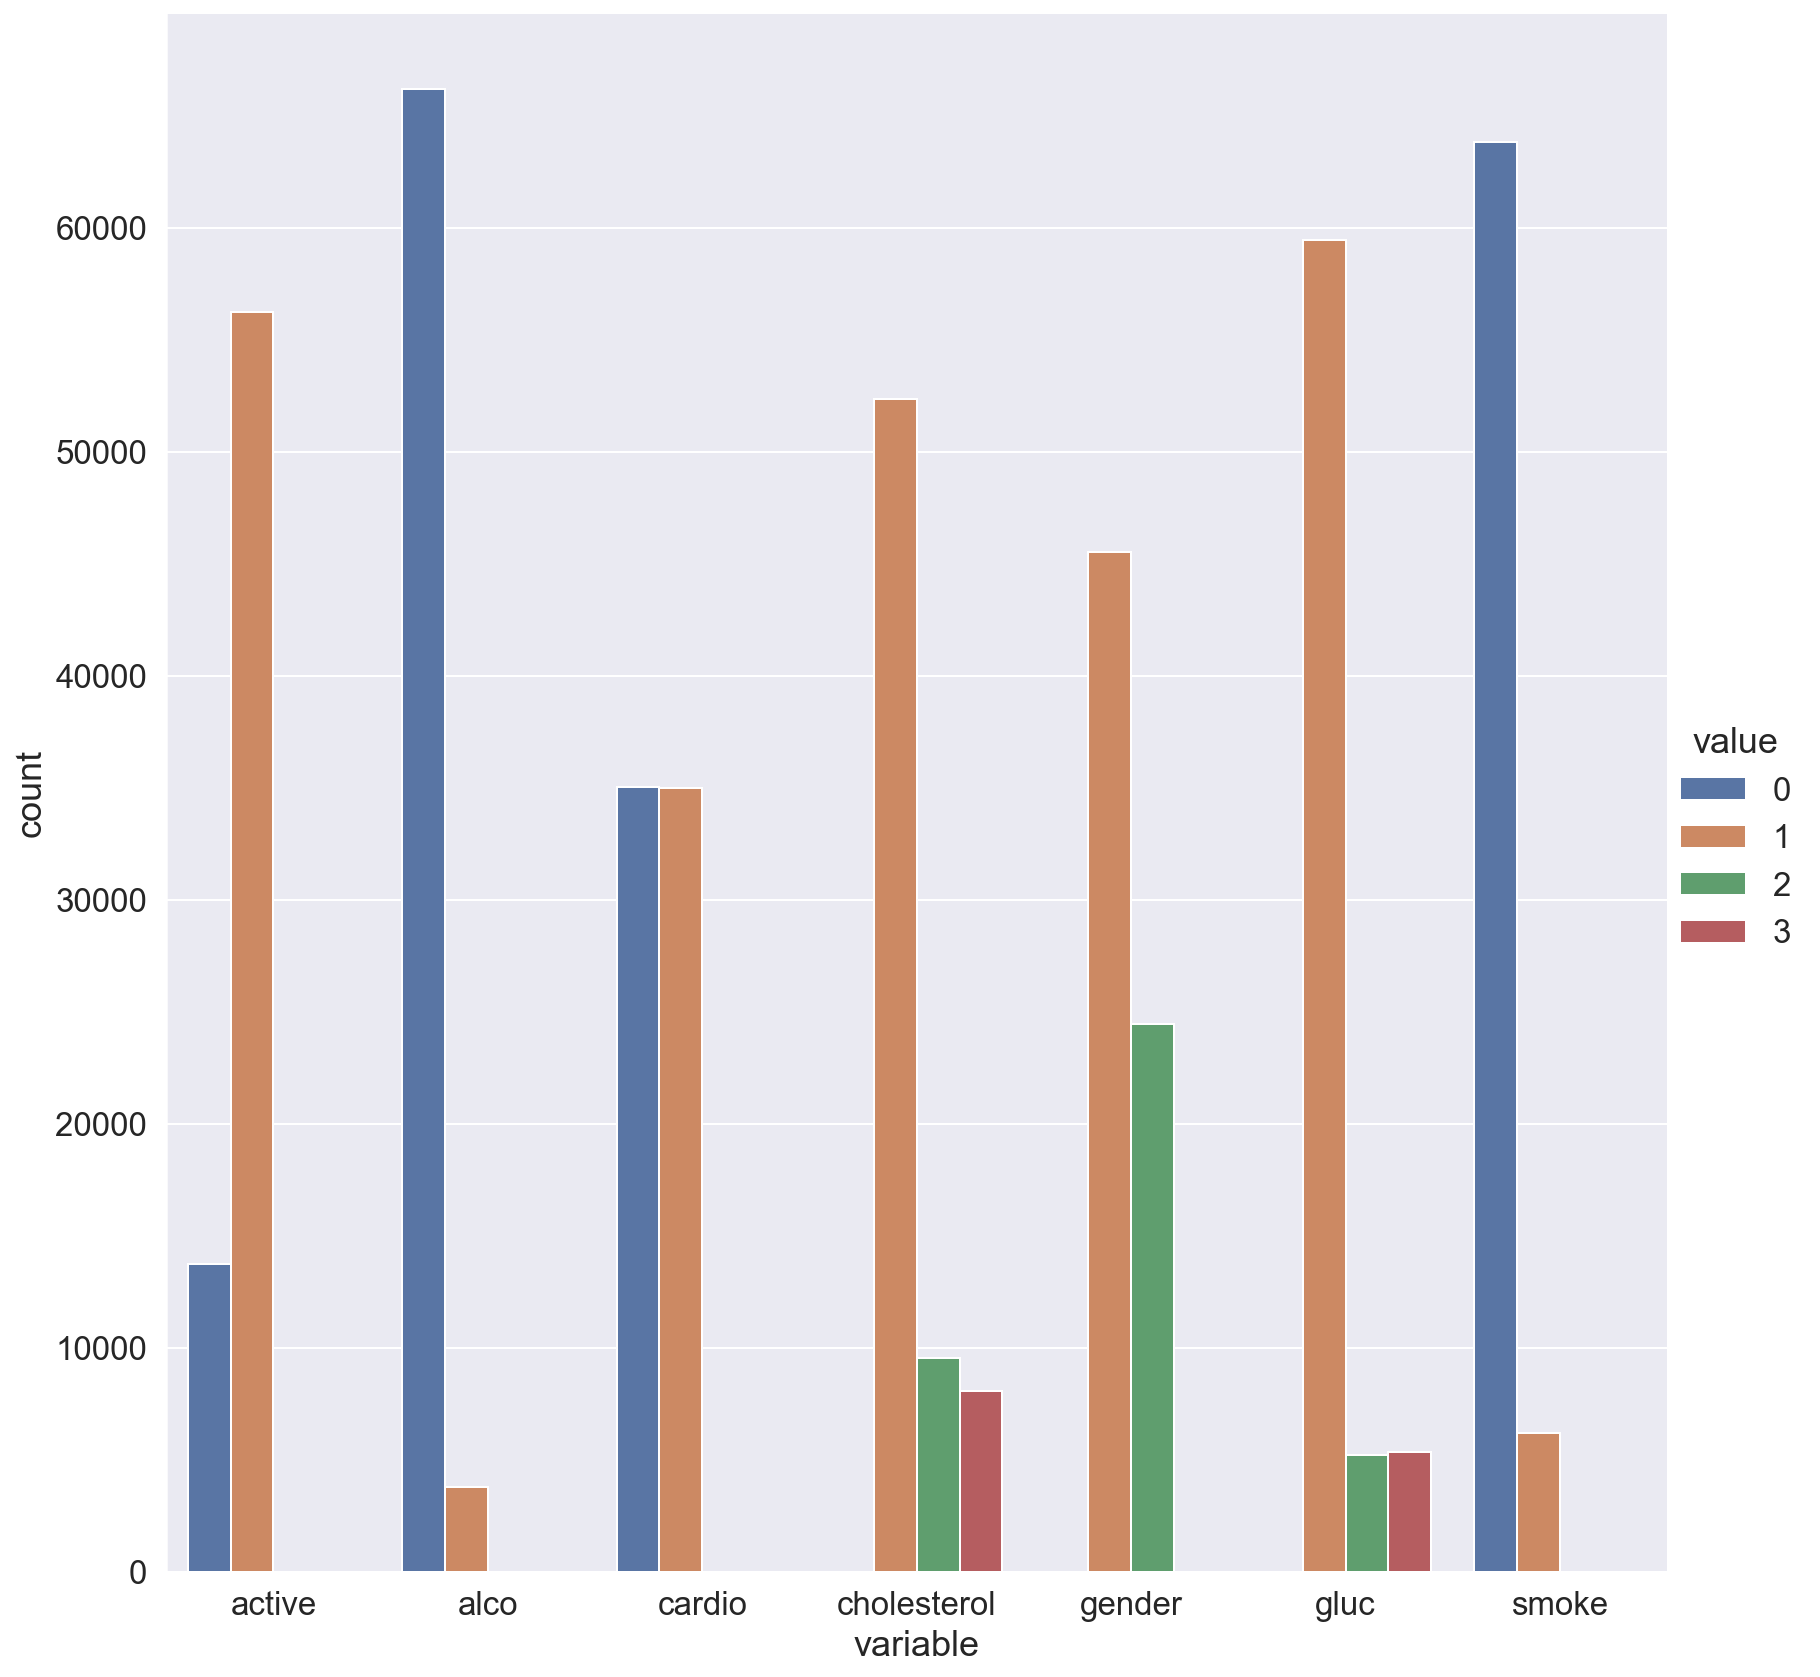

In [4]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", size=12
);

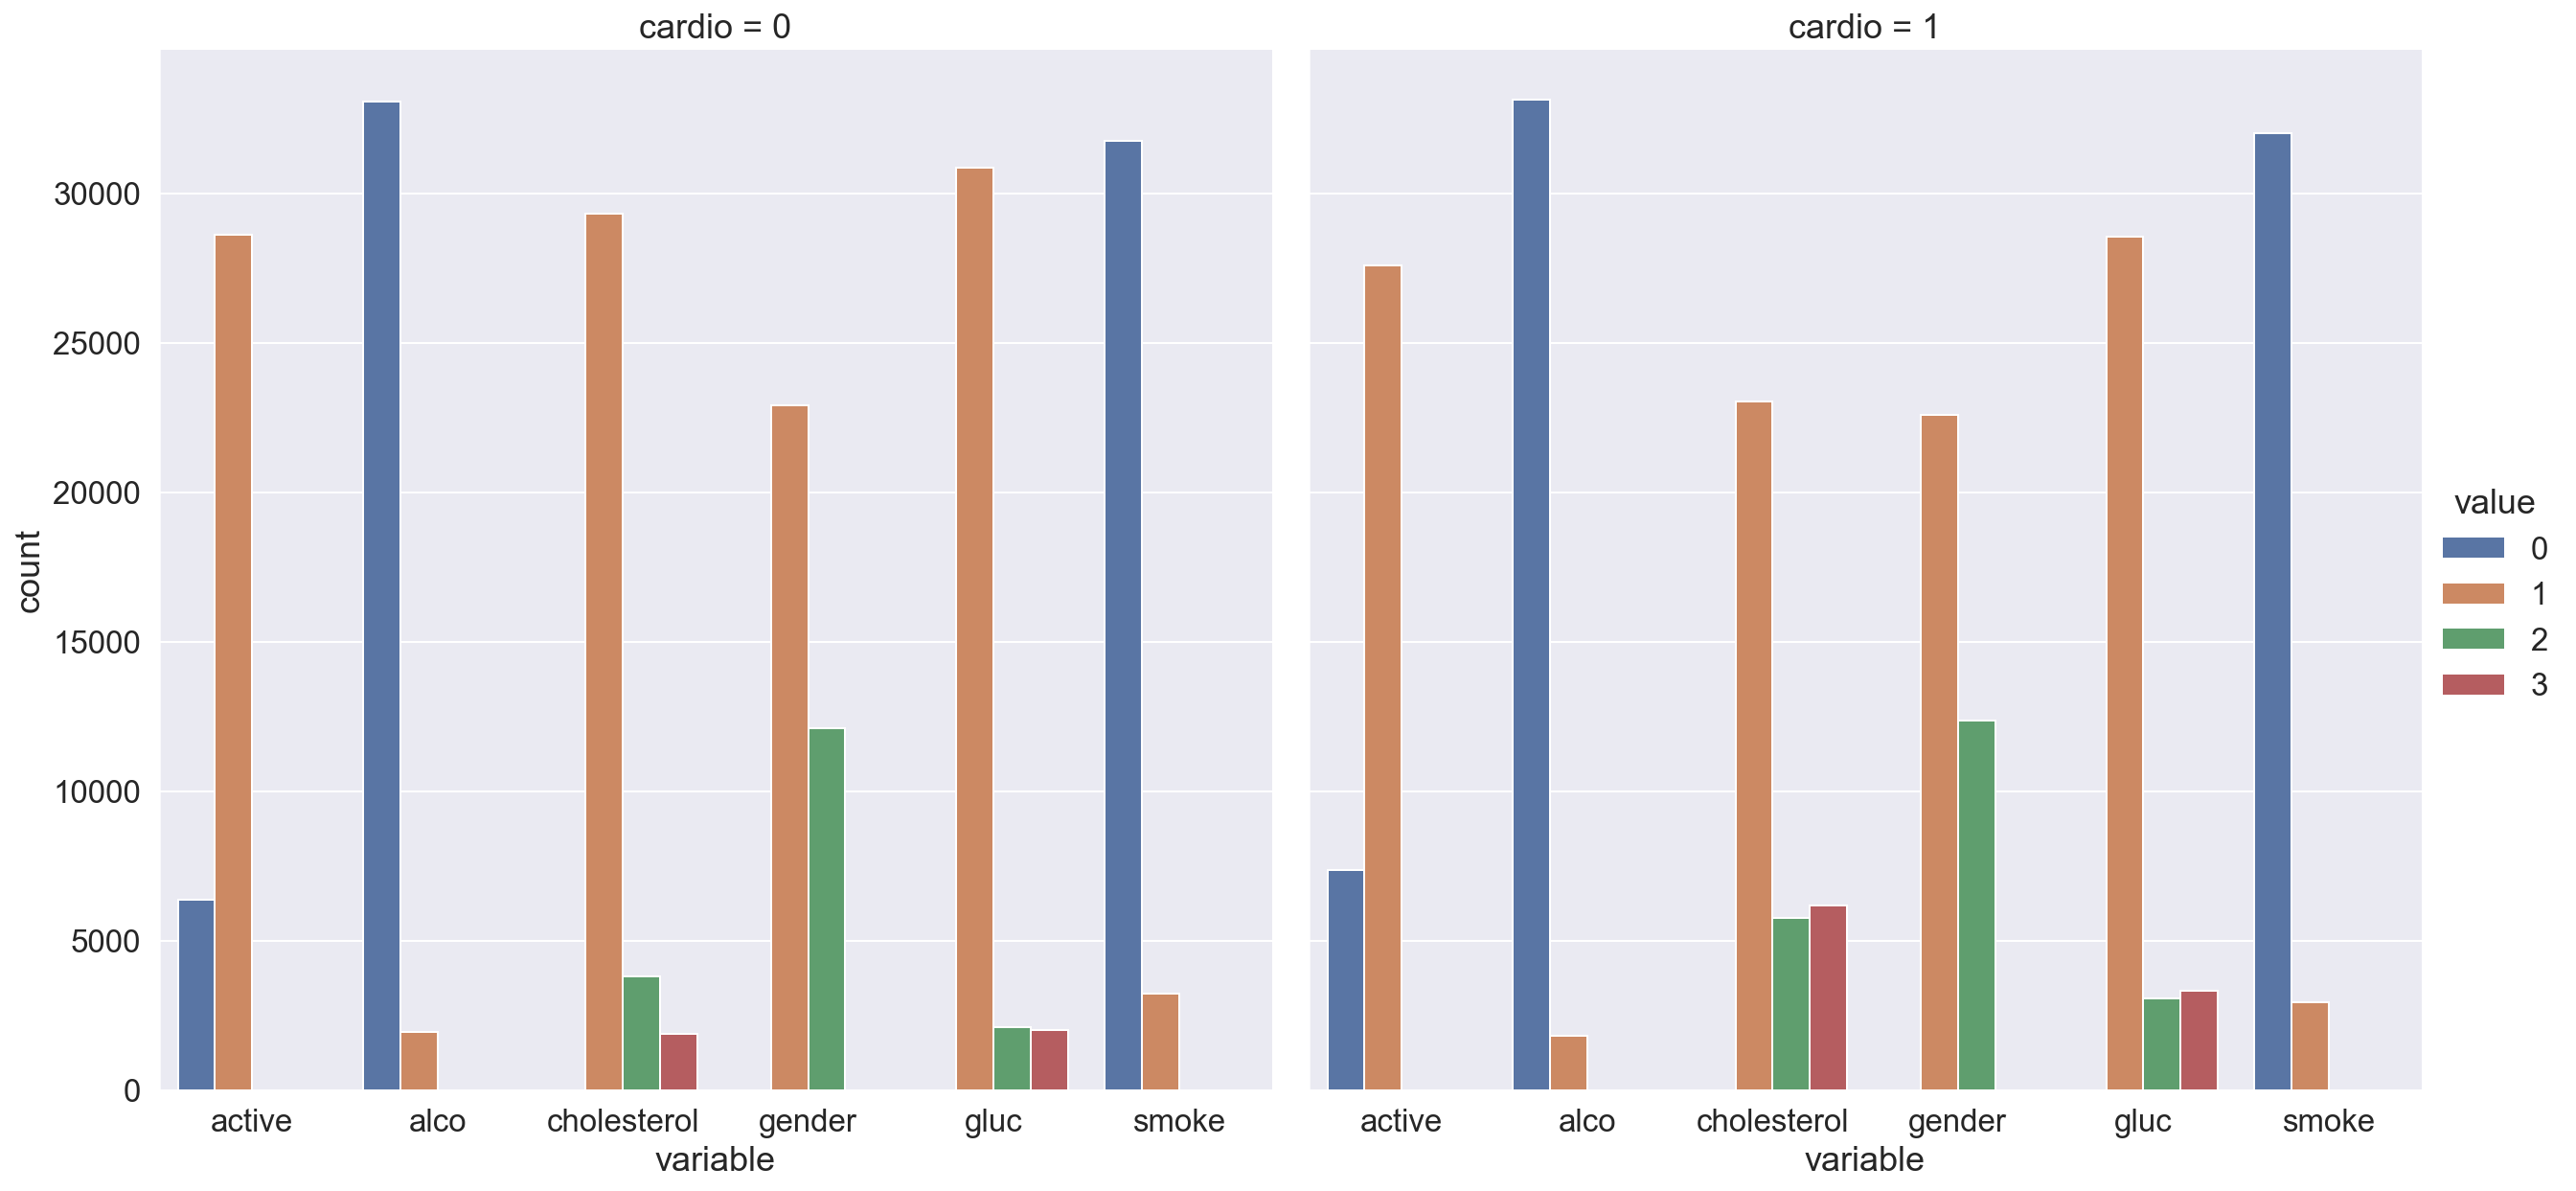

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    size=9,
);

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


## 1.1. Basic observations

### Question 1.1. How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [7]:
df.groupby("gender")["height"].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

Answer: 45530 men and 24470 women

### Question 1.2. Which gender more often reports consuming alcohol - men or women?

In [8]:
df.groupby("gender")["alco"].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

Answer: men

### Question 1.3. What is the difference between the percentages of smokers among men and women (rounded)?

In [9]:
df.groupby("gender")["smoke"].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

In [10]:
round(
    100
    * (
        df.loc[df["gender"] == 2, "smoke"].mean()
        - df.loc[df["gender"] == 1, "smoke"].mean()
    )
)

20

Answer: 3

### Question 1.4. What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You’ll need to figure out the units of feature age in this dataset.

In [11]:
df.groupby("smoke")["age"].median() / 365.25

smoke
0    53.995893
1    52.361396
Name: age, dtype: float64

In [12]:
(
    df[df["smoke"] == 0]["age"].median() - df[df["smoke"] == 1]["age"].median()
) / 365.25 * 12

19.613963039014372

Answer: 20

### Question 1.5. Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?

In [13]:
df["age_years"] = (df["age"] / 365.25).round().astype("int")

In [14]:
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

In [15]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

0.2631578947368421

In [16]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()

0.8636363636363636

Answer: 3

## 1.3. Analyzing BMI

Create a new feature – BMI (Body Mass Index).

In [17]:
df['BMI'] = round(df['weight']/((df['height']/100)**2), 2)

In [18]:
df['BMI']

0        21.97
1        34.93
2        23.51
3        28.71
4        23.01
         ...  
69995    26.93
69996    50.47
69997    31.35
69998    27.10
69999    24.91
Name: BMI, Length: 70000, dtype: float64

### Question 1.6. Choose the correct statements:

<b>Median BMI in the sample is within the range of normal BMI values.

In [19]:
df['BMI'].median()

26.375

Normal BMI values are said to be from 18.5 to 25.  
26.375 is not normal BMI  
Statement is False

<b>The BMI for women is on average higher than for men.

In [20]:
df.groupby("gender")["BMI"].median()

gender
1    26.71
2    25.91
Name: BMI, dtype: float64

BMI of women is 26.71  
BMI of men is 25.91  
Statement is True

<b>Healthy people have, on average, a higher BMI than the people with CVD.

In [21]:
df.groupby(["cardio"])["BMI"].median()

cardio
0    25.48
1    27.47
Name: BMI, dtype: float64

BMI of people without CVD is 25.48  
BMI of people with CVD is 27.47  
Statement is False

<b>For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [22]:
df.groupby(["gender", "alco", "cardio"])["BMI"].median()

gender  alco  cardio
1       0     0         25.65
              1         27.89
        1     0         27.89
              1         30.11
2       0     0         25.10
              1         26.67
        1     0         25.35
              1         27.53
Name: BMI, dtype: float64

Statement is True

## 1.4. Cleaning data

<b>Question 1.7. What percent of the original data (rounded) did we throw away

In [23]:
df_to_remove = df[
    (df["ap_lo"] > df["ap_hi"])
    | (df["height"] < df["height"].quantile(0.025))
    | (df["height"] > df["height"].quantile(0.975))
    | (df["weight"] < df["weight"].quantile(0.025))
    | (df["weight"] > df["weight"].quantile(0.975))
]
print(df_to_remove.shape[0] / df.shape[0])

filtered_df = df[~df.index.isin(df_to_remove)]

0.0963


Answer: 3

## Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

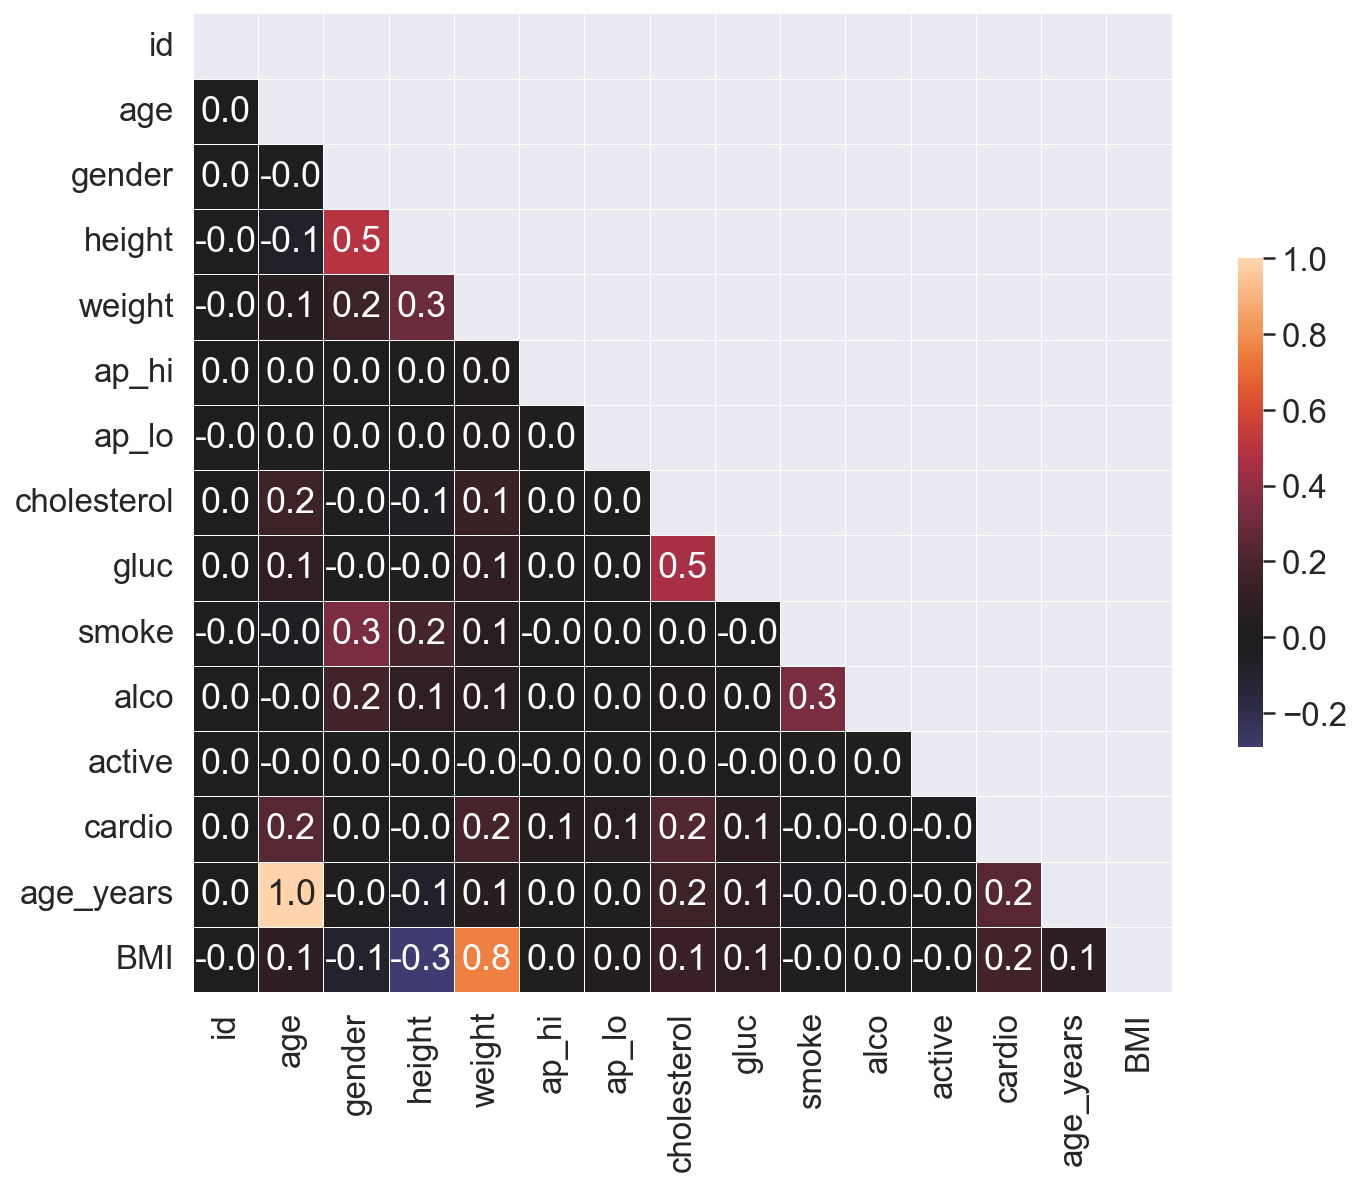

In [24]:
df = filtered_df.copy()

corr = df.corr(method="pearson")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".1f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

### Question 2.1. Which pair of features has the strongest Pearson’s correlation with the gender feature?

Answer: 2

## 2.2. Height distribution of men and women

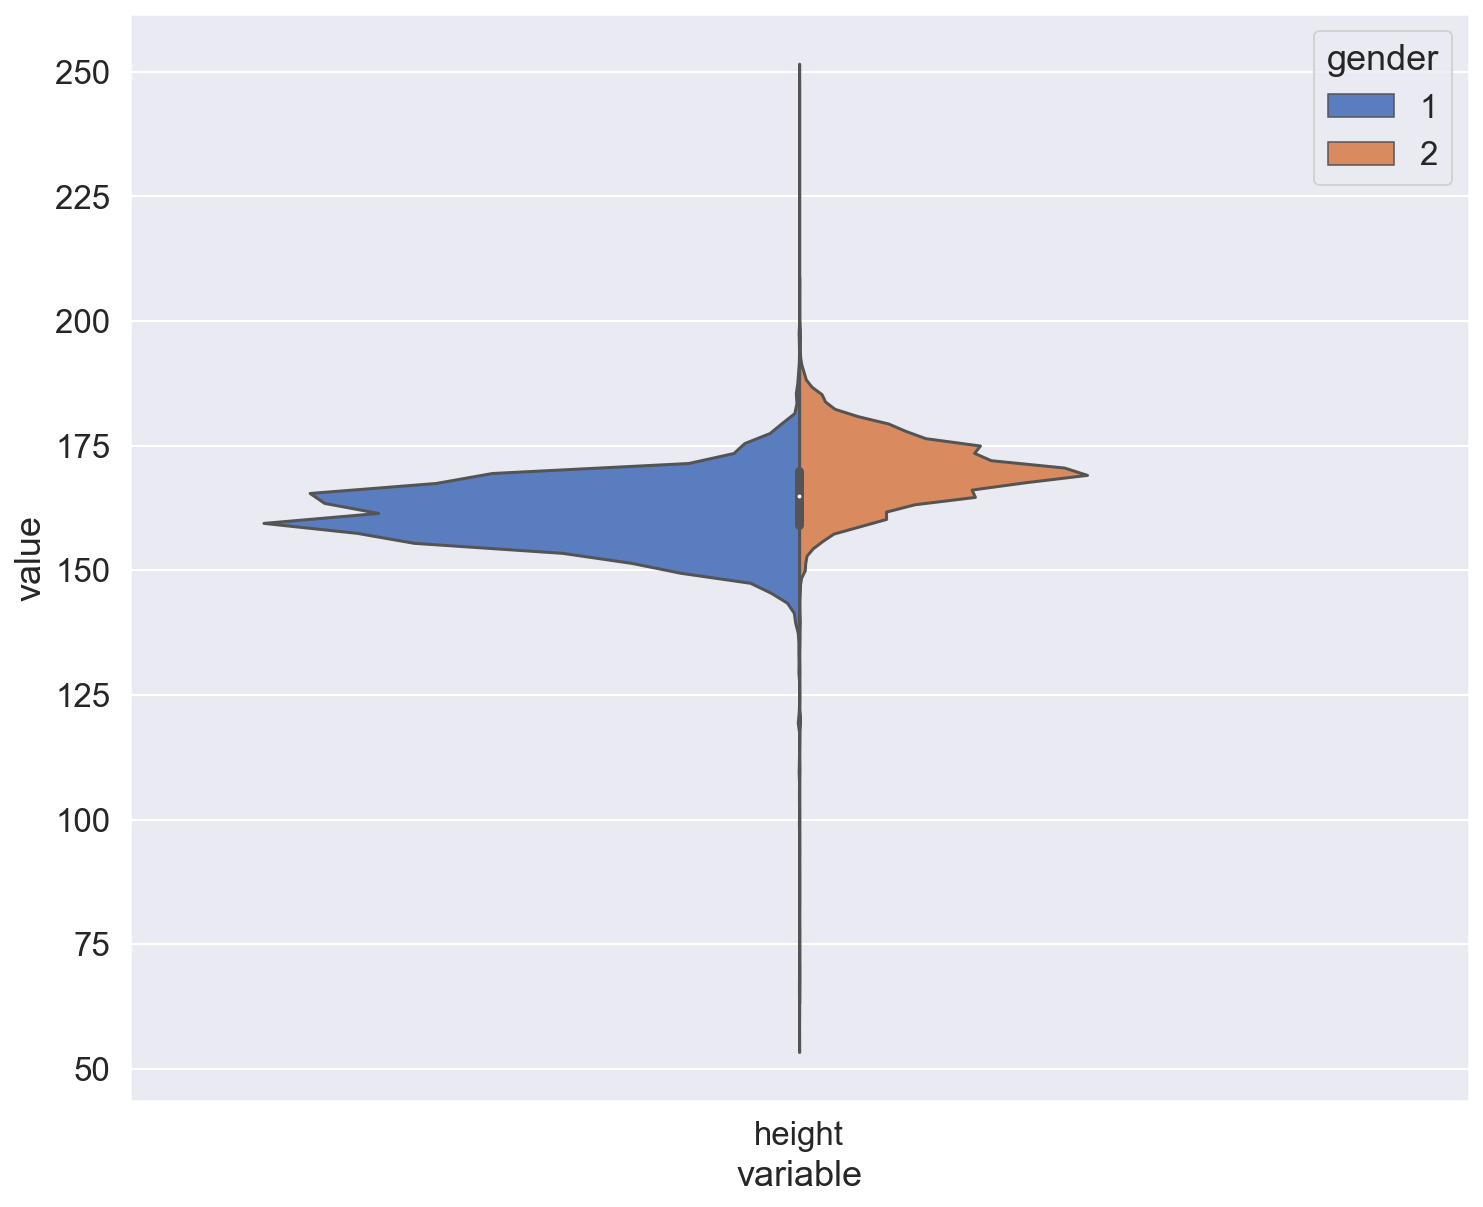

In [25]:
melt_df = pd.melt(df, value_vars=['height'], id_vars=['gender'])
plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x="variable",
    y="value",
    hue="gender",
    palette="muted",
    split=True,
    data=melt_df,
    scale="count",
    scale_hue=False,
)

## 2.3. Rank correlation

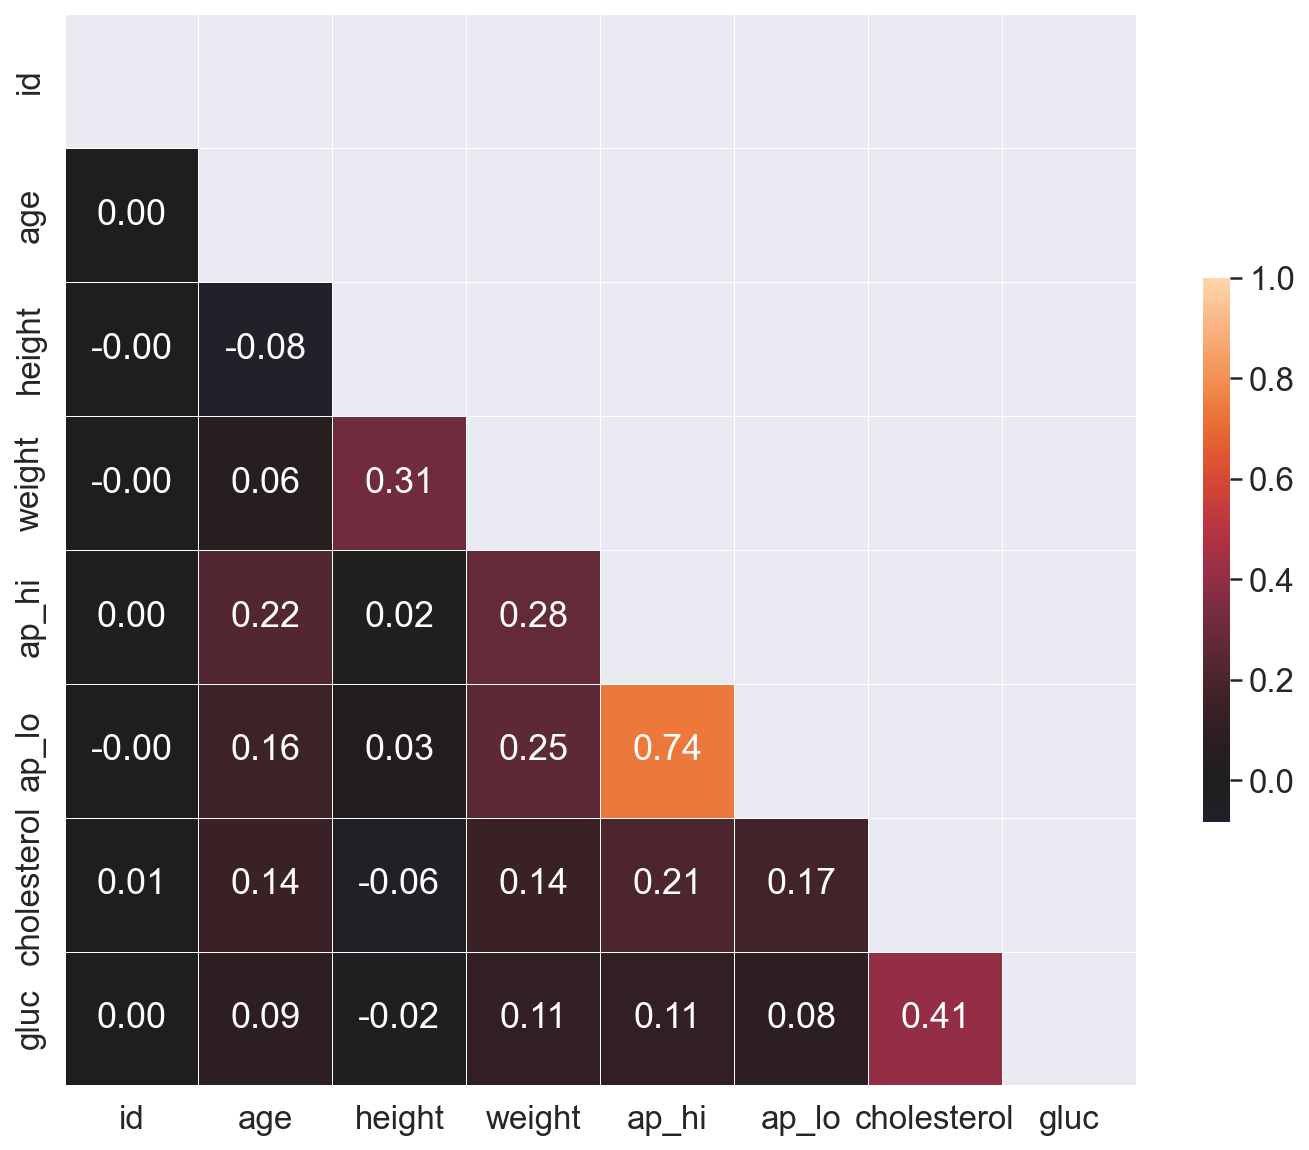

In [26]:
corr = df[
    ["id", "age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"]
].corr(method="spearman")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

### Question 2.2. Which pair of features has the strongest Spearman correlation?

Strongest correlation: Ap_hi, Ap_lo  
Answer: 5

## 2.4. Age

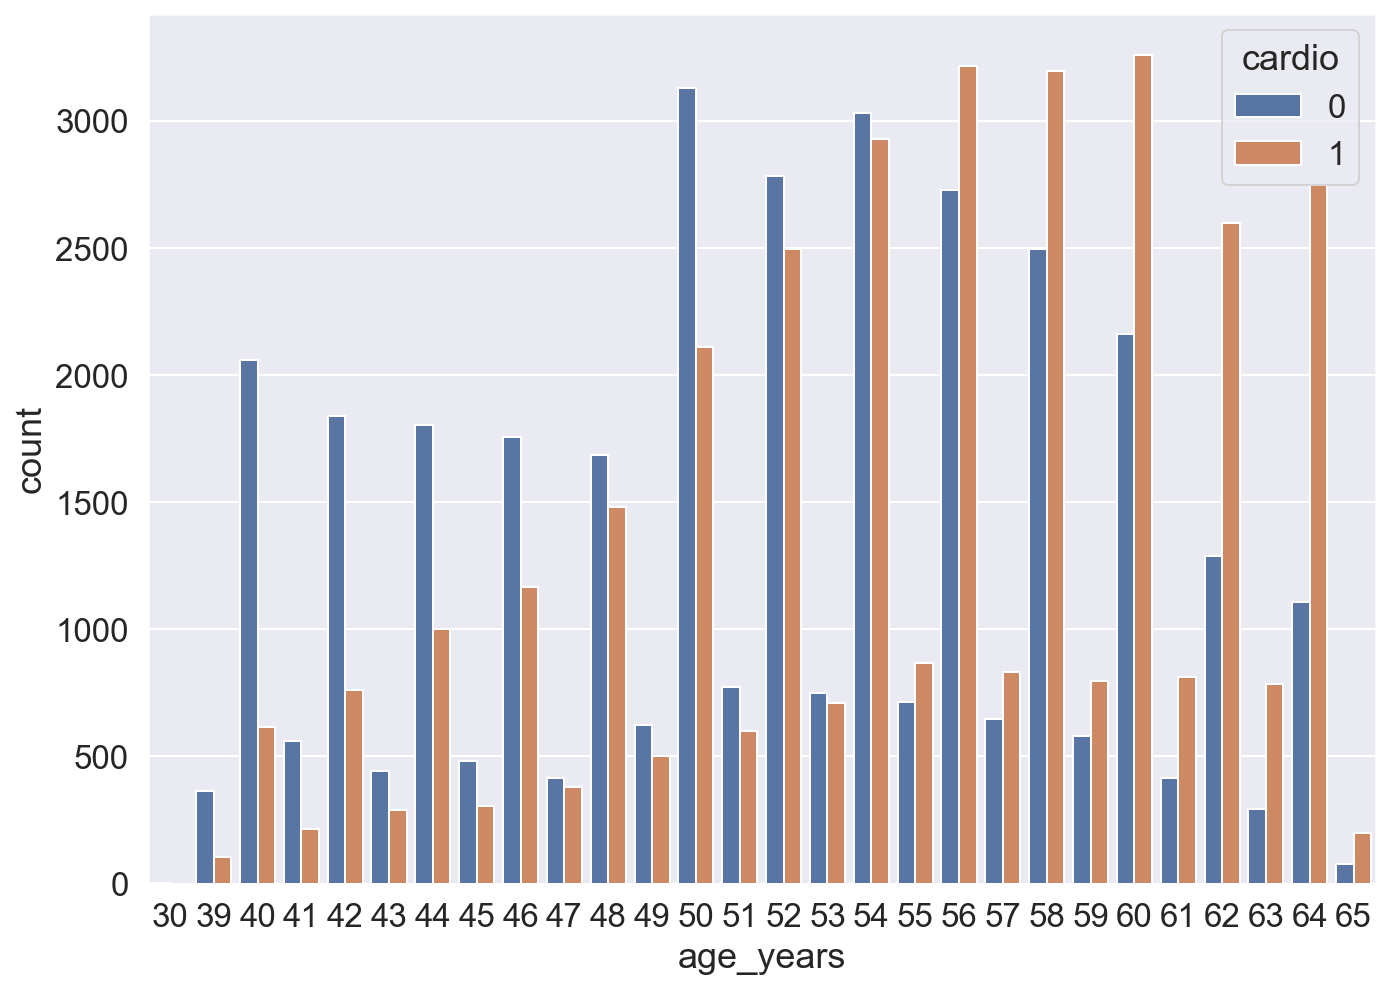

In [27]:
sns.countplot(x="age_years", hue="cardio", data=df);

### Question 2.4. At what age does the number of people with CVD outnumber the number of people without CVD for the first time?

At the age of 55 years
Answer: 2